# 1. Set up the notebook

Import modules.

In [2]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML
np.set_printoptions(suppress=True)

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [3]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to compute RMSE.

In [4]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [5]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

Define the rotation matrix $R_1^0$ as a function of the yaw angle $\psi$, the pitch angle $\theta$, and the roll angle $\phi$.

In [6]:
# Define symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define rotation about the body-fixed z axis by psi
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

# Define rotation about the body-fixed y axis by theta
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

# Define rotation about the body-fixed x axis by phi
Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

# Apply sequential transformation to compute the rotation
# matrix R_1in0 that describes the orientation of the drone
# (i.e., of frame 1 in the coordinates of frame 0)
R_1in0 = Rz @ Ry @ Rx

# Create a function that returns R_1in0 as a numpy array
R_1in0 = sym.lambdify((psi, theta, phi), R_1in0)

# Delete variables that are no longer needed
del psi, theta, phi, Rz, Ry, Rx

# 2. Flight tests to debug observer implementation

## 2.1 Take-off test

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION AND VIDEO OF FLIGHT TEST.**

Load and parse data.

In [42]:
# flight test data
data = load_hardware_data('takeoff_1_data.json', only_in_flight=True)

# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Convert the estimates of linear velocity that come from the default observer from the world frame (i.e., frame 0) to the body frame (i.e., frame 1) by applying the following coordinate transformation at each time step:

$$v_{0, 1}^1 = \left(R_1^0\right)^T v_{0, 1}^0.$$

This is necessary in order to compare the estimates of linear velocity that come from the default observer to the estimates of linear velocity that come from your custom observer.

In [43]:
# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], phi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]

Apply offline implementation of custom observer.

**FIXME: If the observer you are implementing offline (here) is different from the observer you implemented online (in firmware, to produce this flight test), then replace this cell with a description of what you changed (e.g., weights) and why.**

In [56]:
# L = np.array([ 0.        , -0.        , 17.03995305,  0.02751938,  0.        ,
#         0.        , -0.        , -0.04848485,  0.        ,  0.30040458,
#         0.        ,  0.        ,  0.        ,  0.37556625, -0.        ,
#        -0.        , -0.        , 80.2       ])

L = np.array([ 0.        ,  0.        , 10.61555463,  0.00142   , -0.        ,
        0.        ,  0.        , -0.00256   , -0.        ,  0.05889339,
       -0.        ,  0.        , -0.        ,  0.07877584,  0.        ,
        0.        ,  0.        , 40.1       ])
# Define constants
g = 9.81
k_flow = 4.09255568
o_z_eq = 0.5
dt = 0.01

# Get inputs
w_x_offline = data['ae483log.w_x']
w_y_offline = data['ae483log.w_y']
w_z_offline = data['ae483log.w_z']
a_z_offline = data['ae483log.a_z']

# Get outputs
n_x_offline = data['ae483log.n_x']
n_y_offline = data['ae483log.n_y']
r_offline = data['ae483log.r']

# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_offline = np.zeros(len(t))
o_y_offline = np.zeros(len(t))
o_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

s_hat_eq = np.array([[o_z_eq],[0.0],[0.0],[0.0],[0.0],[0.0]])
# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]

    # Compute each element of:
    #
    #  C x + D u - y
    #
#     y = [[n_x],[n_y],[r]]
    
#     s_hat = np.array([[o_z_offline[i-1]],[theta_offline[i-1]],[phi_offline[i-1]],[v_x_offline[i-1]],[v_y_offline[i-1]],[v_z_offline[i-1]]])
#     inp = np.array([[w_x],[w_y],[w_z],[a_z - g]])
#     s_hat += dt*(A_obs@(s_hat) + B_obs@(inp) - L_good@(C_obs@(s_hat) + D_obs@inp - y))
    
    meas = np.array([2*k_flow*v_x - k_flow*w_y - n_x,
                    2*k_flow*v_y + k_flow*w_x - n_y,
                    o_z - r])
    
    # Update estimates
    o_x += dt * (v_x)
    o_y += dt * (v_y)
    o_z += dt*(v_z - L[2]*meas[2])
    psi += dt * (w_z)
    theta += dt * (w_y - L[3]*meas[0])
    phi += dt * (w_x - L[7]*meas[1])
    v_x += dt * (g*theta - L[9]*meas[0])
    v_y += dt * (-g*phi - L[13]*meas[1])
    v_z += dt * (a_z - g - L[17]*meas[2])

    # Store estimates (do not change)
    o_x_offline[i] = o_x
    o_y_offline[i] = o_y
    o_z_offline[i] = o_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z

Compare state estimates from default and custom observers.

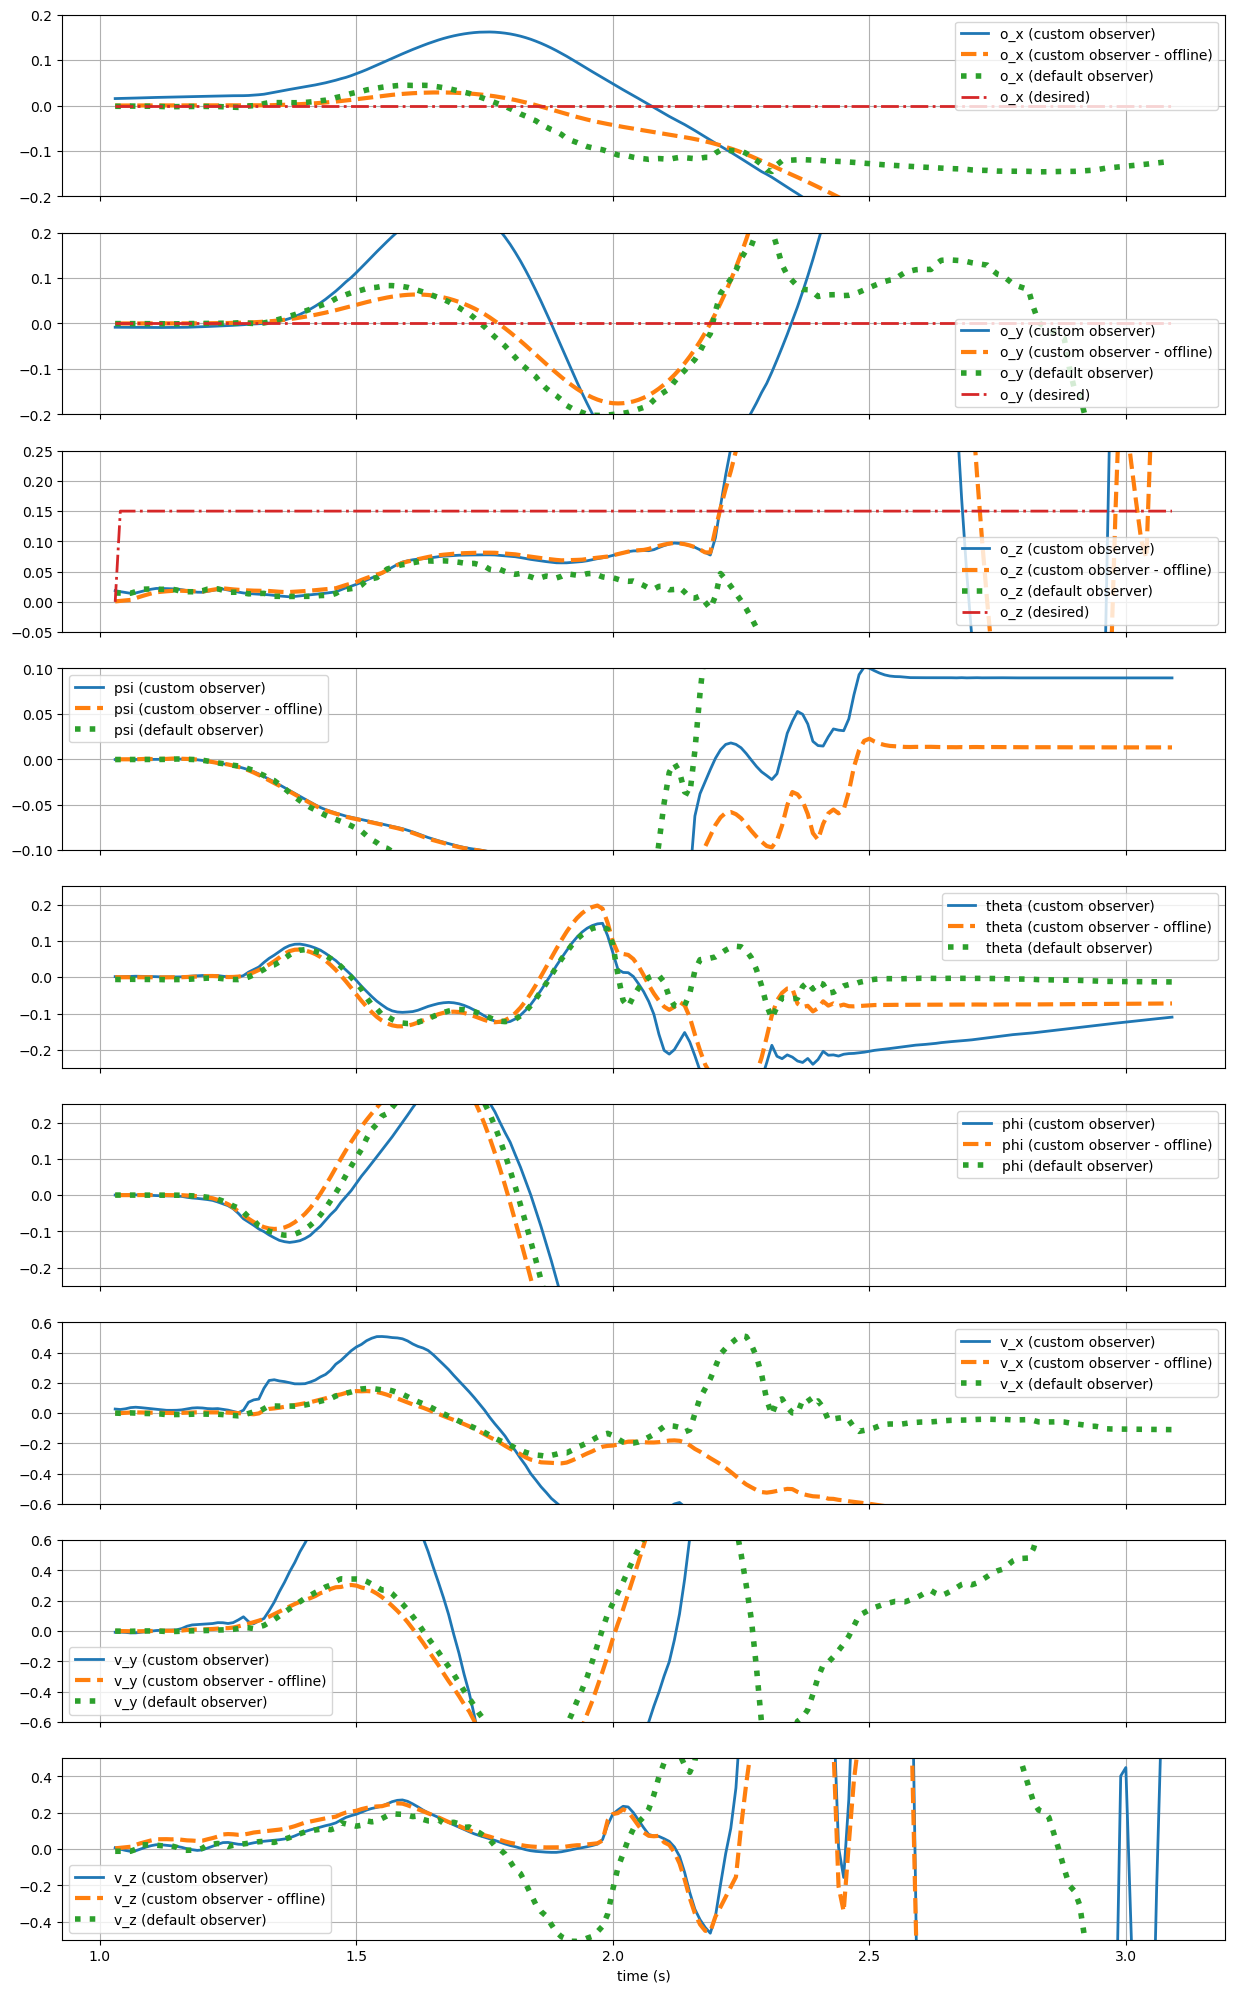

In [57]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (custom observer)', linewidth=2)
    ax.plot(t, s_offline, '--', label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, ':', label=f'{name} (default observer)', linewidth=4)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

ax_o_x.set_ylim([-0.2, 0.2])
ax_o_y.set_ylim([-0.2, 0.2])
ax_o_z.set_ylim([-0.05, 0.25])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.25, 0.25])
ax_phi.set_ylim([-0.25, 0.25])
ax_v_x.set_ylim([-0.6, 0.6])
ax_v_y.set_ylim([-0.6, 0.6])
ax_v_z.set_ylim([-0.5, 0.5])

plt.show()

# 3. Flight tests to compare performance at hover

## 3.1 Hover with default controller and observer

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION AND VIDEO OF FLIGHT TEST.**

Load and parse flight test data.

In [ ]:
# flight test data
data = load_hardware_data('hover_1_data.json', only_in_flight=True)

# times
t = data['time']

# position and orientation
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = -np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])

# desired position
o_x_des = data['ctrltarget.x']
o_y_des = data['ctrltarget.y']
o_z_des = data['ctrltarget.z']

Plot position, desired position, and orientation.

In [ ]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
px = ax_pos.plot(t, o_x_default, label=f'o_x')
py = ax_pos.plot(t, o_y_default, label=f'o_y')
pz = ax_pos.plot(t, o_z_default, label=f'o_z')
ax_pos.plot(t, o_x_des, '--', label=f'o_x (desired)', color=px[0].get_color())
ax_pos.plot(t, o_y_des, '--', label=f'o_y (desired)', color=py[0].get_color())
ax_pos.plot(t, o_z_des, '--', label=f'o_z (desired)', color=pz[0].get_color())
ax_pos.set_ylim([-0.1, 0.6])
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi_default, label='psi')
ax_ori.plot(t, theta_default, label='theta')
ax_ori.plot(t, phi_default, label='phi')
ax_ori.set_ylim([-0.1, 0.1])
ax_ori.legend()
ax_ori.grid()
ax_ori.set_xlabel('time (s)')
ax_ori.set_xlim([0, 14])
plt.show()

Compute RMSE between states (from default observer) and their desired values **over the entire flight test**.

In [ ]:
print(f'RMSE from t={t[0]} to t={t[-1]} (with targets shown at right):')
print(f' o_x:   {rmse(o_x_default, o_x_des):7.3f}  / {0.075:7.3f}')
print(f' o_y:   {rmse(o_y_default, o_y_des):7.3f}  / {0.075:7.3f}')
print(f' o_z:   {rmse(o_z_default, o_z_des):7.3f}  / {0.075:7.3f}')
print(f' psi:   {rmse(psi_default, 0.):7.3f}  / {0.05:7.3f}')
print(f' theta: {rmse(theta_default, 0.):7.3f}  / {0.015:7.3f}')
print(f' phi:   {rmse(phi_default, 0.):7.3f}  / {0.015:7.3f}')

## 3.2 Hover with custom controller and default observer

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION AND VIDEO OF FLIGHT TEST.**

Load and parse flight test data.

In [ ]:
# flight test data
data = load_hardware_data('hover_2_data.json', only_in_flight=True)

# times
t = data['time']

# position and orientation
o_x_default = data['ae483log.o_x']
o_y_default = data['ae483log.o_y']
o_z_default = data['ae483log.o_z']
psi_default = data['ae483log.psi']
theta_default = data['ae483log.theta']
phi_default = data['ae483log.phi']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Plot position, desired position, and orientation.

In [ ]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
px = ax_pos.plot(t, o_x_default, label=f'o_x')
py = ax_pos.plot(t, o_y_default, label=f'o_y')
pz = ax_pos.plot(t, o_z_default, label=f'o_z')
ax_pos.plot(t, o_x_des, '--', label=f'o_x (desired)', color=px[0].get_color())
ax_pos.plot(t, o_y_des, '--', label=f'o_y (desired)', color=py[0].get_color())
ax_pos.plot(t, o_z_des, '--', label=f'o_z (desired)', color=pz[0].get_color())
ax_pos.set_ylim([-0.1, 0.6])
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi_default, label='psi')
ax_ori.plot(t, theta_default, label='theta')
ax_ori.plot(t, phi_default, label='phi')
ax_ori.set_ylim([-0.1, 0.1])
ax_ori.legend()
ax_ori.grid()
ax_ori.set_xlabel('time (s)')
ax_ori.set_xlim([0, 14])
plt.show()

Compute RMSE between states (from default observer) and their desired values **over the entire flight test**.

In [ ]:
print(f'RMSE from t={t[0]} to t={t[-1]} (with targets shown at right):')
print(f' o_x:   {rmse(o_x_default, o_x_des):7.3f}  / {0.075:7.3f}')
print(f' o_y:   {rmse(o_y_default, o_y_des):7.3f}  / {0.075:7.3f}')
print(f' o_z:   {rmse(o_z_default, o_z_des):7.3f}  / {0.075:7.3f}')
print(f' psi:   {rmse(psi_default, 0.):7.3f}  / {0.05:7.3f}')
print(f' theta: {rmse(theta_default, 0.):7.3f}  / {0.015:7.3f}')
print(f' phi:   {rmse(phi_default, 0.):7.3f}  / {0.015:7.3f}')

## 3.3 Hover with custom controller and observer

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION AND VIDEO OF FLIGHT TEST.**

Load and parse flight test data.

In [ ]:
# flight test data
data = load_hardware_data('hover_3_data.json', only_in_flight=True)

# times
t = data['time']

# position and orientation from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = -np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])

# position and orientation from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Plot position, desired position, and orientation (both from default and custom observer) **over the entire flight test**.

In [ ]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
px = ax_pos.plot(t, o_x_custom, label=f'o_x (custom observer)')
py = ax_pos.plot(t, o_y_custom, label=f'o_y (custom observer)')
pz = ax_pos.plot(t, o_z_custom, label=f'o_z (custom observer)')
ax_pos.plot(t, o_x_default, ':', label=f'o_x (default observer)', color=px[0].get_color(), linewidth=4)
ax_pos.plot(t, o_y_default, ':', label=f'o_y (default observer)', color=py[0].get_color(), linewidth=4)
ax_pos.plot(t, o_z_default, ':', label=f'o_z (default observer)', color=pz[0].get_color(), linewidth=4)
ax_pos.plot(t, o_x_des, '--', label=f'o_x (desired)', color=px[0].get_color())
ax_pos.plot(t, o_y_des, '--', label=f'o_y (desired)', color=py[0].get_color())
ax_pos.plot(t, o_z_des, '--', label=f'o_z (desired)', color=pz[0].get_color())
ax_pos.set_ylim([-0.1, 0.6])
ax_pos.legend()
ax_pos.grid()
ppsi = ax_ori.plot(t, psi_custom, label=f'psi (custom observer)')
ptheta = ax_ori.plot(t, theta_custom, label=f'theta (custom observer)')
pphi = ax_ori.plot(t, phi_custom, label=f'phi (custom observer)')
ax_ori.plot(t, psi_default, ':', label=f'psi (default observer)', color=ppsi[0].get_color(), linewidth=4)
ax_ori.plot(t, theta_default, ':', label=f'theta (default observer)', color=ptheta[0].get_color(), linewidth=4)
ax_ori.plot(t, phi_default, ':', label=f'phi (default observer)', color=pphi[0].get_color(), linewidth=4)
ax_ori.set_ylim([-0.1, 0.1])
ax_ori.legend()
ax_ori.grid()
ax_ori.set_xlabel('time (s)')
ax_ori.set_xlim([0, 14])
plt.show()

Compute RMSE between states (from custom observer) and their desired values.

In [ ]:
print(f'RMSE from t={t[0]} to t={t[-1]} (with targets shown at right):')
print(f' o_x:   {rmse(o_x_custom, o_x_des):7.3f}  / {0.075:7.3f}')
print(f' o_y:   {rmse(o_y_custom, o_y_des):7.3f}  / {0.075:7.3f}')
print(f' o_z:   {rmse(o_z_custom, o_z_des):7.3f}  / {0.075:7.3f}')
print(f' psi:   {rmse(psi_custom, 0.):7.3f}  / {0.05:7.3f}')
print(f' theta: {rmse(theta_custom, 0.):7.3f}  / {0.015:7.3f}')
print(f' phi:   {rmse(phi_custom, 0.):7.3f}  / {0.015:7.3f}')

## 3.4 Summary and discussion

The following table reports the RMSE in each component of position and of orientation:

|  | $o_x$ | $o_y$ | $o_z$ | $\psi$ | $\theta$ | $\phi$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE in hover test (default controller, default observer) | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| RMSE in hover test (custom controller, default observer) | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| RMSE in move test (custom controller, custom observer) | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |

**Modify the text in this cell** to answer the following questions:

* Are you able to match the performance of the default controller and observer (top row) with your controller and observer (bottom row)? Do the results when using the custom controller with the default observer (middle row) help explain any differences in performance?
* What about your observer design (if anything) did you have to change in order to get your custom controller and observer to work well? Why were these changes necessary?

# 4. Flight test while moving in squares

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION AND VIDEO OF FLIGHT TEST.**

Load and parse flight test data.

In [ ]:
# flight test data
data = load_hardware_data('move_data.json', only_in_flight=True)

# times
t = data['time']

# position and orientation from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = -np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])

# position and orientation from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Plot position, desired position, and orientation (both from default and custom observer) **over the entire flight test**.

In [ ]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
px = ax_pos.plot(t, o_x_custom, label=f'o_x (custom observer)')
py = ax_pos.plot(t, o_y_custom, label=f'o_y (custom observer)')
pz = ax_pos.plot(t, o_z_custom, label=f'o_z (custom observer)')
ax_pos.plot(t, o_x_default, ':', label=f'o_x (default observer)', color=px[0].get_color(), linewidth=4)
ax_pos.plot(t, o_y_default, ':', label=f'o_y (default observer)', color=py[0].get_color(), linewidth=4)
ax_pos.plot(t, o_z_default, ':', label=f'o_z (default observer)', color=pz[0].get_color(), linewidth=4)
ax_pos.plot(t, o_x_des, '--', label=f'o_x (desired)', color=px[0].get_color())
ax_pos.plot(t, o_y_des, '--', label=f'o_y (desired)', color=py[0].get_color())
ax_pos.plot(t, o_z_des, '--', label=f'o_z (desired)', color=pz[0].get_color())
ax_pos.legend()
ax_pos.grid()
ppsi = ax_ori.plot(t, psi_custom, label=f'psi (custom observer)')
ptheta = ax_ori.plot(t, theta_custom, label=f'theta (custom observer)')
pphi = ax_ori.plot(t, phi_custom, label=f'phi (custom observer)')
ax_ori.plot(t, psi_default, ':', label=f'psi (default observer)', color=ppsi[0].get_color(), linewidth=4)
ax_ori.plot(t, theta_default, ':', label=f'theta (default observer)', color=ptheta[0].get_color(), linewidth=4)
ax_ori.plot(t, phi_default, ':', label=f'phi (default observer)', color=pphi[0].get_color(), linewidth=4)
ax_ori.legend()
ax_ori.grid()
ax_ori.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(o_x_custom, o_y_custom, label='position (custom observer)')
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

**FIXME: REPLACE THIS CELL WITH A DISCUSSION OF RESULTS.**

First, fill in the following table:

| | $o_x$ (meters) | $o_y$ (meters) |
| ---: | :---: | :---: |
| landing position (measured by ruler) | 0.000 | 0.000 |
| landing position (from custom observer) | 0.000 | 0.000 |
| landing position (from default observer) | 0.000 | 0.000 |

Then, answer the following questions:

* Last week, you may have noticed that position estimates from the default observer appeared "good" and position estimates from the custom observer appeared "bad". This week, you may have noticed the opposite. What is going on here? Which state estimates are correct? (Are *any* of them correct?) Like last week, you will want to compare the landing position that you measured with a ruler to the final position that was estimated by each observer, and will also want to think about which states are observable (and about what that means).
* To what extent does your code enable the drone to track a desired position? It may help to look at the top-down plot when answering this question. Are there ways you could improve tracking performance?